# Corrosion detection in steel pipes

* **The objective**:
The objective of this challenge is to train a model that have the highest possible score for the segmentation of groove defects using the provided data

# Install Packages

In [ ]:
#install packages
!pip install imutils
!pip install torchsummary

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import imutils.paths as paths
import glob
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from PIL import Image
from torch.optim import Adam
from torchsummary import summary
from tqdm import tqdm
import random
import shutil
import cv2
from scipy.ndimage import binary_fill_holes
import pandas as pd
from pathlib import Path

In [31]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Look at the data


In [3]:
# Read file
y_train=pd.read_csv('../data/raw/y_train.csv',index_col=0) #Table with index being the name of the patch
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9674 entries, well_10_patch_0 to well_15_patch_99
Columns: 1296 entries, 0 to 1295
dtypes: int64(1296)
memory usage: 95.7+ MB


In [4]:
display(y_train.head())

,0,1,2,3,4,5,6,7,8,9,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
well_10_patch_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
dict_wells_masks = {}


for name_patch in y_train.index:
    if (int(name_patch[5:7].replace('_', '')) in dict_wells_masks.keys()):
        dict_wells_masks[int(name_patch[5:7].replace('_', ''))] += 1
        
    else:
        dict_wells_masks[int(name_patch[5:7].replace('_', ''))]  = 1


for key in dict(sorted(dict_wells_masks.items())).keys():
    print('Well :',key, 'Number of patches :', dict_wells_masks[key])

print('Total number of wells :',len(dict_wells_masks.keys()))
print('Total number of patches :', sum(dict_wells_masks.values()))

# First well and 450 first images of well 1 are false

Well : 1 Number of patches : 166
Well : 2 Number of patches : 616
Well : 3 Number of patches : 1774
Well : 4 Number of patches : 59
Well : 5 Number of patches : 98
Well : 6 Number of patches : 964
Well : 7 Number of patches : 1654
Well : 8 Number of patches : 78
Well : 9 Number of patches : 166
Well : 10 Number of patches : 80
Well : 11 Number of patches : 1512
Well : 12 Number of patches : 44
Well : 13 Number of patches : 1905
Well : 14 Number of patches : 355
Well : 15 Number of patches : 203
Total number of wells : 15
Total number of patches : 9674


In [6]:
folder_path = '../data/raw/images'  
file_names = os.listdir(folder_path)

dict_wells_images = {}


for name_patch in file_names:
    if (int(name_patch[5:7].replace('_', '')) in dict_wells_images.keys()):
        dict_wells_images[int(name_patch[5:7].replace('_', ''))] += 1
        
    else:
        dict_wells_images[int(name_patch[5:7].replace('_', ''))]  = 1


for key in dict(sorted(dict_wells_images.items())).keys():
    print('Well :',key, 'Number of patches :', dict_wells_images[key])

print('Total number of wells :',len(dict_wells_images.keys()))
print('Total number of patches :', sum(dict_wells_images.values()))

Well : 1 Number of patches : 166
Well : 2 Number of patches : 616
Well : 3 Number of patches : 1774
Well : 4 Number of patches : 59
Well : 5 Number of patches : 98
Well : 6 Number of patches : 964
Well : 7 Number of patches : 1654
Well : 8 Number of patches : 78
Well : 9 Number of patches : 166
Well : 10 Number of patches : 80
Well : 11 Number of patches : 1512
Well : 12 Number of patches : 44
Well : 13 Number of patches : 1905
Well : 14 Number of patches : 355
Well : 15 Number of patches : 203
Total number of wells : 15
Total number of patches : 9674


In [7]:
y_keys = dict(sorted(dict_wells_masks.items())).keys()
image_keys = dict(sorted(dict_wells_images.items())).keys()

for i, key in enumerate(y_keys):
    print('Mask well :',key, 'Number of patches :', dict_wells_masks[key])
    if i == 15:
        break
    print('Image well :',list(image_keys)[i], 'Number of patches :', dict_wells_images[list(image_keys)[i]],'\n')

Mask well : 1 Number of patches : 166
Image well : 1 Number of patches : 166 

Mask well : 2 Number of patches : 616
Image well : 2 Number of patches : 616 

Mask well : 3 Number of patches : 1774
Image well : 3 Number of patches : 1774 

Mask well : 4 Number of patches : 59
Image well : 4 Number of patches : 59 

Mask well : 5 Number of patches : 98
Image well : 5 Number of patches : 98 

Mask well : 6 Number of patches : 964
Image well : 6 Number of patches : 964 

Mask well : 7 Number of patches : 1654
Image well : 7 Number of patches : 1654 

Mask well : 8 Number of patches : 78
Image well : 8 Number of patches : 78 

Mask well : 9 Number of patches : 166
Image well : 9 Number of patches : 166 

Mask well : 10 Number of patches : 80
Image well : 10 Number of patches : 80 

Mask well : 11 Number of patches : 1512
Image well : 11 Number of patches : 1512 

Mask well : 12 Number of patches : 44
Image well : 12 Number of patches : 44 

Mask well : 13 Number of patches : 1905
Image well

## Imbalance analysis

In [8]:
n_patches = 0
n_pixels = 0
overall = 0
for row in y_train.iterrows():

    psum = np.sum(row[1]) 
    if psum > 0:
        n_patches += 1
        n_pixels += psum
    overall += len(row[1])

In [9]:
print('Number of patches with corrosion :', n_patches)
print('Number of pixels with corrosion :', n_pixels)
print('Overall number of pixels :', overall)    
print('Ratio of pixels with corrosion :', round(n_pixels*100/overall, ndigits= 3),'%')
print('Ratio of patches with corrosion :', round(n_patches*100/len(y_train), ndigits=3),'%')

Number of patches with corrosion : 7674
Number of pixels with corrosion : 896993
Overall number of pixels : 12537504
Ratio of pixels with corrosion : 7.154 %
Ratio of patches with corrosion : 79.326 %


## Preprocessing analysis

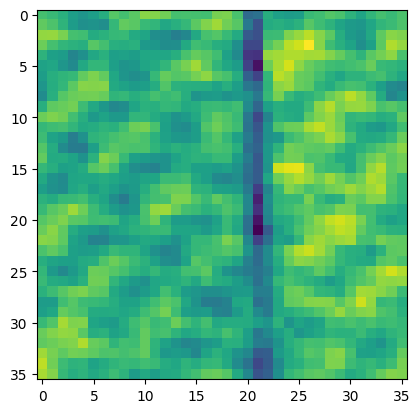

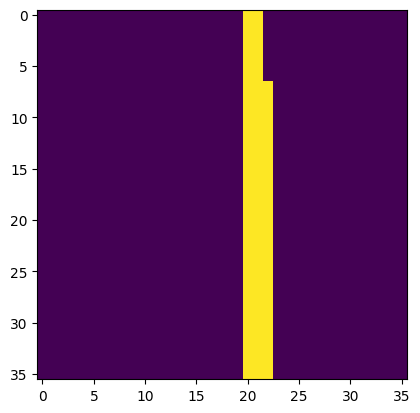

In [10]:
image = np.load('../data/raw/images/well_2_patch_3.npy')
plt.imshow(image)
plt.show()

mask = np.array(y_train.loc['well_2_patch_3']).reshape(36,36)
plt.imshow(mask)
plt.show()

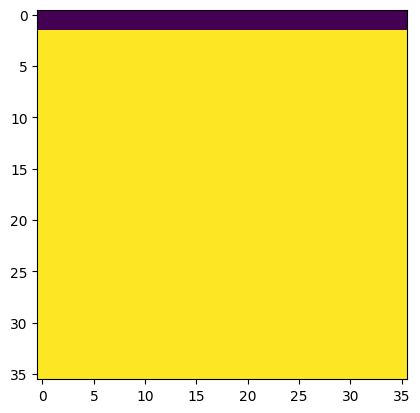

In [11]:
# Data analysis
file_names = os.listdir('../data/raw/images/')
images = []
for img_name in file_names:
    img = np.load(os.path.join('../data/raw/images/',
                               img_name))
    if np.sum(img < -800) > 0:
        plt.imshow(img)
        plt.show()
        break
        
    images.append(img)

In [12]:
np.min(img),np.max(img), np.unique(img)

(np.float32(-999.0),
 np.float32(0.02619489),
 array([-9.9900000e+02, -6.0668353e-02, -6.0539667e-02, ...,
         2.5462953e-02,  2.5556546e-02,  2.6194889e-02], dtype=float32))

In [13]:
 # Data analysis
file_names = os.listdir('../data/raw/images/')
images_train = []
count_outliers = 0
for img_name in tqdm(file_names):
    # print(img_name)
    img = np.load(os.path.join('../data/raw/images/',
                               img_name))
    if img.min() < -100:
        count_outliers += 1 
        

    images_train.append(img)
flat_list_img_train = np.array(images_train).flatten()  
print('Number patches train set:',len(images_train))
print('Number of outliers:',count_outliers*100/len(file_names))

100%|██████████| 9674/9674 [00:03<00:00, 2946.30it/s]


Number patches train set: 9674
Number of outliers: 3.514575149886293


In [14]:
# Statistics on the train images

cleaned_img = np.nan_to_num(flat_list_img_train)
print('For the training images :')
print('Mean :',np.mean(cleaned_img))
print('Std :',np.std(cleaned_img))
print('Max :',np.max(cleaned_img))
print('Min :',np.min(cleaned_img))



For the training images :
Mean : -4.650981
Std : 68.01066
Max : 0.4703434
Min : -999.25


100%|██████████| 9674/9674 [00:03<00:00, 2964.92it/s]


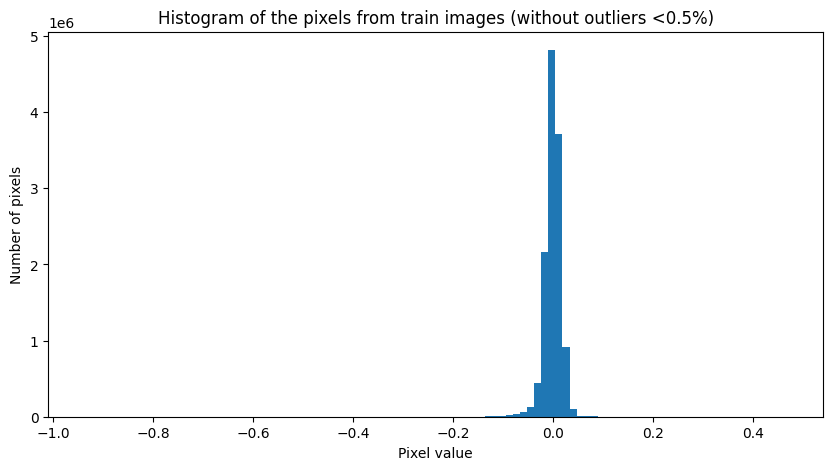

Ratio outliers pixels: 0.465 %


In [15]:
file_names = os.listdir('../data/raw/images/')
images_train = []
count_outliers = 0
for img_name in tqdm(file_names):
    # print(img_name)
    img = np.load(os.path.join('../data/raw/images/',
                               img_name))
    if img.min() < -100:
        count_outliers += 1 

    images_train.append(img)
flat_list_img_train = np.array(images_train).flatten() 
cleaned_img = np.nan_to_num(flat_list_img_train)
plt.figure(figsize=(10, 5))
plt.hist(cleaned_img[cleaned_img > -100] , bins=100)
plt.title('Histogram of the pixels from train images (without outliers <0.5%)')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.show()
print('Ratio outliers pixels:',round(len(cleaned_img[cleaned_img <-100])*100/len(cleaned_img),ndigits=3),'%')

# Preparing The Dataset

In [16]:
#convert df to bunch of numpy array- masks
import numpy as np
import os

# Set the directory where the .npy files will be saved
save_dir = '../data/raw/masks'

# Iterate over the rows of the dataframe
for index, row in y_train.iterrows():
    # Reshape the row into a 36x36 numpy array
    arr = np.array(row).reshape(36, 36)

    # Set the file name as the index of the dataframe
    file_name = f'{index}.npy'

    # Save the numpy array as a .npy file in the specified directory
    np.save(os.path.join(save_dir, file_name), arr)

In [17]:
# Define paths
train_images_dir = "../data/raw/images"
train_masks_dir = "../data/raw/masks"


train_data = [(os.path.join(train_images_dir, filename), os.path.join(train_masks_dir, filename)) for filename in os.listdir(train_images_dir)]


# Shuffle the merged data
random.shuffle(train_data)

# Define split ratio (e.g., 80% train, 20% validation)
split_ratio = 0.90
train_size = int(len(train_data) * split_ratio)
train_images, train_masks = zip(*train_data[:train_size])
val_images, val_masks = zip(*train_data[train_size:])

# Define new directories
new_train_images_dir = "../data/interim/train/images"
new_train_masks_dir = "../data/interim/train/masks"
new_val_images_dir = "../data/interim/val/images"
new_val_masks_dir = "../data/interim/val/masks"

# Create new directories
os.makedirs(new_train_images_dir, exist_ok=True)
os.makedirs(new_train_masks_dir, exist_ok=True)
os.makedirs(new_val_images_dir, exist_ok=True)
os.makedirs(new_val_masks_dir, exist_ok=True)

for src, dest in zip(train_images, [os.path.join(new_train_images_dir, os.path.basename(img)) for img in train_images]):
    shutil.copy(src, dest)

for src, dest in zip(train_masks, [os.path.join(new_train_masks_dir, os.path.basename(mask)) for mask in train_masks]):
    shutil.copy(src, dest)

for src, dest in zip(val_images, [os.path.join(new_val_images_dir, os.path.basename(img)) for img in val_images]):
    shutil.copy(src, dest)

for src, dest in zip(val_masks, [os.path.join(new_val_masks_dir, os.path.basename(mask)) for mask in val_masks]):
    shutil.copy(src, dest)

print("Data merging and splitting complete.")


Data merging and splitting complete.


# Visualize some Images and the Masks from the Data

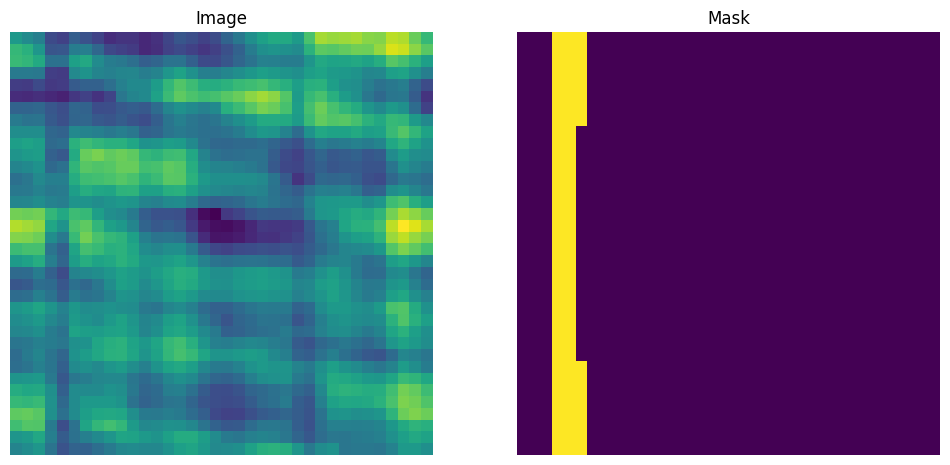

In [26]:
#Path
image_path = "../data/interim/train/images/well_5_patch_50.npy"
mask_path = "../data/interim/train/masks/well_5_patch_50.npy"
# Load
image = np.load(image_path)
mask = np.load(mask_path)
mask = binary_fill_holes(mask)
# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask)
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()

In [27]:
#Print the size of the mask and the image
print(image.shape)
print(mask.shape)

(36, 36)
(36, 36)


# Label Refinement

# binary fill holes

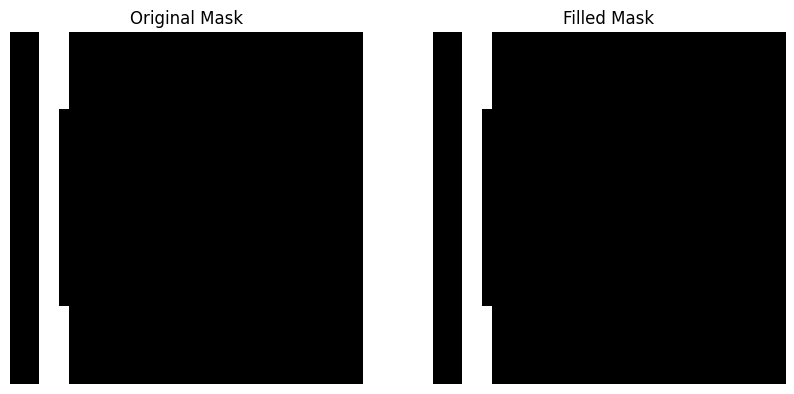

In [28]:
filled = binary_fill_holes(mask)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[0].axis('off')

# Plot filled mask
axes[1].imshow(filled, cmap='gray')
axes[1].set_title('Filled Mask')
axes[1].axis('off')

plt.show()

# Structuring Element & Morphological Operations

In [29]:
kernel_size = (2, 2)
kernel_shape = cv2.MORPH_RECT
# Create the adaptive structuring element
adaptive_kernel = cv2.getStructuringElement(kernel_shape, kernel_size)
# Apply morphological operations : dilation
result = cv2.dilate(mask, adaptive_kernel)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[0].axis('off')
# Plot filled mask
axes[1].imshow(result, cmap='gray')
axes[1].set_title('Dilat  Mask')
axes[1].axis('off')
plt.show()

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'dilate'
> Overload resolution failed:
>  - src data type = bool is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


# Image Enhancement

CLAHE and bilateral filter

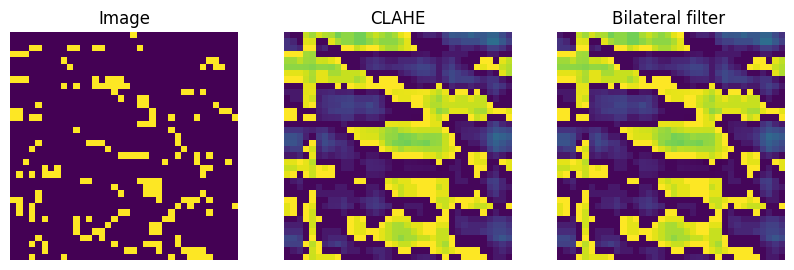

In [30]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
image = np.uint8(image * 255)

# Apply CLAHE to the grayscale image
clahe_img = clahe.apply(image)
#Apply bilateral filter
bilateral_img = cv2.bilateralFilter(clahe_img, d=2, sigmaColor=4, sigmaSpace=4)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# Plot Image
image = np.uint8(image /255)

axes[0].imshow(image)
axes[0].set_title('Image')
axes[0].axis('off')

#  Plot CLAHE result
axes[1].imshow(clahe_img)
axes[1].set_title('CLAHE')
axes[1].axis('off')

# Plot Bilateral filter
axes[2].imshow(clahe_img/255)
axes[2].set_title('Bilateral filter ')
axes[2].axis('off')
plt.show()

# Dataset Class

In [31]:
from scipy.ndimage import rotate

class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, filelist, transform=True):
        self.imagePaths = [os.path.join(imagePaths, file) for file in filelist]
        self.maskPaths = [os.path.join(maskPaths, file) for file in filelist]
        self.transform = transform
        self.valid_indices = self._get_valid_indices()

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        idx = self.valid_indices[idx]  # Get the valid index
        imagePath = self.imagePaths[idx]
        maskPath = self.maskPaths[idx]

        # Read image from file
        image = np.load(imagePath)
        if image is None or np.isnan(image).any():
            # Skip images with NaN values
            return self.__getitem__((idx + 1) % len(self.valid_indices))

        # Read mask from file
        mask = np.load(maskPath)
        if mask is None:
            raise FileNotFoundError(f"Mask file not found: {maskPath}")

        if self.transform:
            image, mask = self.apply_numpy_transform(image, mask)

        """kernel_size = (2, 2)
        kernel_shape = cv2.MORPH_RECT
        adaptive_kernel = cv2.getStructuringElement(kernel_shape, kernel_size)
        mask = cv2.dilate(mask, adaptive_kernel)"""
        mask = binary_fill_holes(mask)

        # Convert to PyTorch tensors
        image = torch.from_numpy(np.array(image)).float()
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask, imagePath, maskPath

    def _get_valid_indices(self):
        valid_indices = []
        for idx, imagePath in enumerate(self.imagePaths):
            image = np.load(imagePath)
            if image is not None and not np.isnan(image).any():
                valid_indices.append(idx)
        return valid_indices


    def apply_numpy_transform(self, image, mask):
        # Apply horizontal and vertical flips with 50% probability
        if np.random.random() > 0.5:
            image = np.fliplr(image)  # Horizontal flip
            mask = np.fliplr(mask)
        if np.random.random() > 0.5:
            image = np.flipud(image)  # Vertical flip
            mask = np.flipud(mask)
        """# Apply 90 and 135-degree rotations with 50% probability
        if np.random.random() > 0.5:
            rotation_angle = np.random.choice([0, 45, 90, 180,135])
            if rotation_angle != 0:
                image = rotate(image, angle=rotation_angle, reshape=False)
                mask = rotate(mask, angle=rotation_angle, reshape=False)"""

        return image, mask


# Models for Segmentation

# UNET Model

We have chosen a compact architecture for the UNET model 🏗️ consisting of:

- 3 down-sampling blocks: (36 x 36), (18 x 18), and (9 x 9).
- 3 up-sampling blocks: (9 x 9), (18 x 18), and (36 x 36).

Here's an illustration of the UNET model:

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*VUS2cCaPB45wcHHFp_fQZQ.png" alt="UNET Model" width="500" height="250">



In [32]:
class UNet(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(UNet, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.maxpool = nn.MaxPool2d(2, 2)

        # Additional layers in encoder
        self.enc_conv1_additional = nn.Conv2d(32, 32, 3, padding=1)
        self.enc_conv2_additional = nn.Conv2d(64, 64, 3, padding=1)

        # Dropout layers
        self.dropout = nn.Dropout2d(p=dropout_prob)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.final_conv = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        # Encoder
        x1 = torch.relu(self.enc_conv1(x))
        x1 = torch.relu(self.enc_conv1_additional(x1))
        x2 = self.maxpool(x1)
        x2 = torch.relu(self.enc_conv2(x2))
        x2 = torch.relu(self.enc_conv2_additional(x2))
        #x2 = self.dropout(x2)
        x3 = self.maxpool(x2)
        x3 = torch.relu(self.enc_conv3(x3))
        x3 = torch.relu(self.enc_conv4(x3))
        #x3 = self.dropout(x3)

        # Decoder
        x = torch.relu(self.upconv1(x3))
        x = torch.cat([x2, x], dim=1)
        x = torch.relu(self.dec_conv1(x))
        x = torch.relu(self.upconv2(x))
        x = torch.cat([x1, x], dim=1)
        x = torch.relu(self.dec_conv2(x))
        x = torch.sigmoid(self.final_conv(x))
        #(x.shape)
        return x

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Initialize the model
model = UNet()
model.to(device)
summary(model, input_size=(1, 36, 36))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 36, 36]             320
            Conv2d-2           [-1, 32, 36, 36]           9,248
         MaxPool2d-3           [-1, 32, 18, 18]               0
            Conv2d-4           [-1, 64, 18, 18]          18,496
            Conv2d-5           [-1, 64, 18, 18]          36,928
         MaxPool2d-6             [-1, 64, 9, 9]               0
            Conv2d-7            [-1, 128, 9, 9]          73,856
            Conv2d-8            [-1, 128, 9, 9]         147,584
   ConvTranspose2d-9           [-1, 64, 18, 18]          32,832
           Conv2d-10           [-1, 64, 18, 18]          73,792
  ConvTranspose2d-11           [-1, 32, 36, 36]           8,224
           Conv2d-12           [-1, 32, 36, 36]          18,464
           Conv2d-13            [-1, 1, 36, 36]              33
Total params: 419,777
Trainable params:

In [34]:
tensor = torch.rand(1,1, 36, 36).to(device)
model(tensor)

tensor([[[[0.5257, 0.5257, 0.5254,  ..., 0.5268, 0.5257, 0.5232],
          [0.5239, 0.5244, 0.5256,  ..., 0.5253, 0.5245, 0.5218],
          [0.5251, 0.5256, 0.5246,  ..., 0.5271, 0.5272, 0.5206],
          ...,
          [0.5236, 0.5259, 0.5261,  ..., 0.5304, 0.5274, 0.5189],
          [0.5244, 0.5255, 0.5257,  ..., 0.5253, 0.5243, 0.5226],
          [0.5233, 0.5268, 0.5223,  ..., 0.5222, 0.5248, 0.5219]]]],
       grad_fn=<SigmoidBackward0>)

# Attention U-Net

We have chosen to incorporate attention mechanisms into the U-Net to enhance focus on the critical regions of the input image.

Here's an illustration of the Attention U-Net architecture:

<img src="https://idiotdeveloper.com/wp-content/uploads/2021/06/attention_unet-compressed-2.jpg" alt="Attention U-Net architecture" width="500" height="250">



In [35]:
class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        result = torch.add(g1, x1)
        psi = self.relu(result)
        #print(g1.shape)
        #print(x1.shape)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out

In [36]:
import torch
import torch.nn as nn

class AttUNet(nn.Module):
    def __init__(self, dropout_prob=0.3):
        super(AttUNet, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.enc_conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.maxpool = nn.MaxPool2d(2, 2)



        # Dropout layers
        self.dropout = nn.Dropout2d(p=dropout_prob)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.Att1 = AttentionBlock(F_g=32, F_l=32, n_coefficients=32)
        self.dec_conv1 = nn.Conv2d(64, 32, 3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.Att2 = AttentionBlock(F_g=16, F_l=16, n_coefficients=16)
        self.dec_conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.final_conv = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        # Encoder
        e1 = torch.relu(self.enc_conv1(x)) #32x36x36
        e2 = self.maxpool(e1) #32x18x18
        e2 = torch.relu(self.enc_conv2(e2)) #64x18x18
        e2 = self.dropout(e2) #64x18x18
        e3 = self.maxpool(e2) #64x9x9
        e3 = torch.relu(self.enc_conv3(e3)) #128x9x9
        elif3 = torch.relu(self.enc_conv4(e3)) #128x9x9
        e3 = self.dropout(e3)

        # Decoder
        d2 = torch.relu(self.upconv1(e3)) #[2, 64, 18, 18]
        s2 = self.Att1(gate=d2, skip_connection=e2)
        d2 = torch.cat([s2, d2], dim=1)
        d2 = torch.relu(self.dec_conv1(d2))
        #print(d2.shape)
        d1 = torch.relu(self.upconv2(d2))
        #print(e1.shape)
        #print(d1.shape)
        s1 = self.Att2(gate=d1, skip_connection=e1)
        d1 = torch.cat([s1, d1], dim=1)
        #print(d1.shape)
        d1 = torch.relu(self.dec_conv2(d1))
        out = torch.sigmoid(self.final_conv(d1))
        #(x.shape)

        return out


# ResUNet


We have chosen to incorporate  residual connections within the architecture. These residual connections can help to alleviate the vanishing gradient problem and improve the overall performance of the network

Here's an illustration of the ResUNet architecture:

<img src="https://idiotdeveloper.com/wp-content/uploads/2022/01/MultiResUNET.png" alt="ResUNet architecture" width="500" height="250">


In [37]:

class batchnorm_relu(nn.Module):
    def __init__(self, in_c):
        super().__init__()

        self.bn = nn.BatchNorm2d(in_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        return x

class residual_block(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()

        """ Convolutional layer """
        self.b1 = batchnorm_relu(in_c)
        self.c1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
        self.b2 = batchnorm_relu(out_c)
        self.c2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, stride=1)

        """ Shortcut Connection (Identity Mapping) """
        self.s = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0, stride=stride)

    def forward(self, inputs):
        x = self.b1(inputs)
        x = self.c1(x)
        x = self.b2(x)
        x = self.c2(x)
        s = self.s(inputs)

        skip = x + s
        return skip

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.r = residual_block(in_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        #print(x.shape)
        x = torch.cat([x, skip], axis=1)
        x = self.r(x)
        return x

class build_resunet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder 1 """
        self.c11 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.br1 = batchnorm_relu(64)
        self.c12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(1, 64, kernel_size=1, padding=0)

        """ Encoder 2 and 3 """
        self.r2 = residual_block(64, 128, stride=2)
        #self.r3 = residual_block(128, 256, stride=2)

        """ Bridge """
        self.r4 = residual_block(128, 256, stride=2)

        """ Decoder """
        #self.d1 = decoder_block(512, 256)
        self.d2 = decoder_block(256, 128)
        self.d3 = decoder_block(128, 64)

        """ Output """
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        """ Encoder 1 """
        x = self.c11(inputs)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(inputs)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        #skip3 = self.r3(skip2)

        """ Bridge """
        b = self.r4(skip2)

        """ Decoder """
        #d1 = self.d1(b, skip3)
        d2 = self.d2(b, skip2)
        d3 = self.d3(d2, skip1)

        """ output """
        output = self.output(d3)
        output = self.sigmoid(output)

        return output




# Various Losses for Training

Dice Loss + BCE  

In [38]:
class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction
        self.bce=nn.BCELoss()

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth
        bce_loss = self.bce(predict, target)
        loss = (1 - num / den)+bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

Focal Loss

In [39]:
class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param
        self.bce=nn.BCELoss()

    def forward(self, input, target):
        # inputs and targets are assumed to be BatchxClasses
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)
        # compute the negative likelyhood
        bce_loss = self.bce(input.view(-1), target.float().view(-1))
        logpt = - bce_loss
        pt = torch.exp(logpt)
        # compute the loss
        focal_loss = -( (1-pt)**self.gamma ) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        loss=balanced_focal_loss+bce_loss
        return loss

## Start Training

In [ ]:
new_train_images_dir = "../data/interim/train/images"
new_train_masks_dir = "../data/interim/train/masks"
new_val_images_dir = "../data/interim/val/images"
new_val_masks_dir = "../data/interim/val/masks"

In [41]:
#batch size for data loaders
batch_size = 16
# Train Set
IMAGE_DATASET_PATH = "../data/interim/train/images/"
IMAGE_Label_PATH = "../data/interim/train/masks/"
imagePaths_full = sorted(glob.glob(IMAGE_DATASET_PATH + "*.npy"))
imagePaths = [os.path.basename(path) for path in imagePaths_full]
train_dataset = SegmentationDataset(IMAGE_DATASET_PATH, IMAGE_Label_PATH, imagePaths)
# Validation Set
IMAGE_DATASET_PATH_VAL = "../data/interim/val/images/"
IMAGE_Label_PATH_VAL = "../data/interim/val/masks/"
val_imagePaths_full = sorted(glob.glob(IMAGE_DATASET_PATH_VAL + "*.npy"))
val_imagePaths = [os.path.basename(path) for path in val_imagePaths_full]
val_dataset = SegmentationDataset(IMAGE_DATASET_PATH_VAL, IMAGE_Label_PATH_VAL, val_imagePaths)

#Define data loaders
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Displaying Images and Mask from train set :

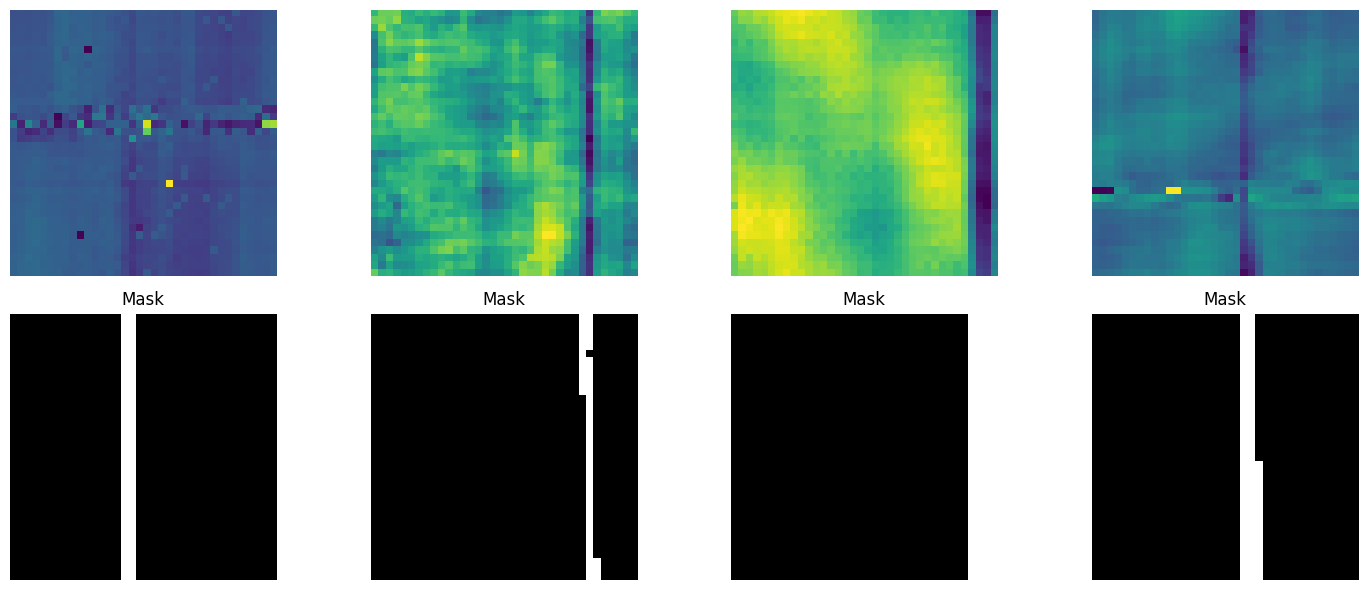

In [42]:
for images, masks,image_path,mask_path in train_loader:
    num_images_to_plot = min(4, len(images))

    fig, axes = plt.subplots(2, num_images_to_plot, figsize=(15, 6))

    for i in range(num_images_to_plot):
        axes[0, i].imshow(images[i])
        #axes[0, i].set_title(image_path[i])
        #print(image_path[i])
        #print(mask_path[i])
        axes[0, i].axis('off')

        axes[1, i].imshow(masks[i], cmap='gray')
        axes[1, i].set_title('Mask')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()
    break

# Evalution Score

Dice Score

In [43]:
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon=1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result

Validation function

In [44]:
#Validation function
def validation(model, val_loader, criterion, device):
    model.eval()
    total_val_loss = 0
    total_val_dice_coef = 0
    sample = 0
    nb_batch = 0
    with torch.no_grad():
        with tqdm(val_loader, desc='Validation', unit='batch') as tqdm_loader:
            for images, masks,_ ,_ in tqdm_loader:
                images = images.to(device)
                masks = masks.to(device)
                masks = masks.float()
                images = images.unsqueeze(1)
                masks = masks.unsqueeze(1)
                pred = model(images)
                val_loss = criterion(pred, masks)
                y_pred = pred.data.cpu().numpy().ravel()
                y_true = masks.data.cpu().numpy().ravel()
                val_dice_coef = dice_coeff(y_pred, y_true)
                total_val_loss += val_loss.item()
                total_val_dice_coef += val_dice_coef.item()
                sample += len(images)
                nb_batch += 1
                tqdm_loader.set_postfix(loss=val_loss.item(), DiceCoef=val_dice_coef.item())
    overall_val_loss = total_val_loss / nb_batch
    overall_val_dice_coef = total_val_dice_coef / nb_batch
    print(f"Validation Loss: {overall_val_loss}")
    print(f"Validation Dice Score Coef: {overall_val_dice_coef}")
    return overall_val_loss,overall_val_dice_coef

# Training

In [46]:
#Model
model = UNet()
model.to(device)
#Hyper Parameters
lr = 0.001
weight_decay = 1e-5
betas = (0.9, 0.999)
optimizer = Adam(model.parameters(), lr=lr)
#criterion = FocalLoss() #FocalLoss + BCE
#criterion =BinaryDiceLoss() #DiceLoss + BCE
criterion = nn.BCELoss() #Binary Score Entropy
num_epochs = 25
train_loss=[]
train_dice_score=[]
validation_loss=[]
validation_dice_score=[]
for e in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_dice_coef = 0
    sample = 0
    nb_batch = 0
    with tqdm(train_loader, desc=f'Epoch {e+1}/{num_epochs}', unit='batch') as tqdm_loader:
        for images, masks,_,_ in tqdm_loader:
            optimizer.zero_grad()
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.float()
            images = images.unsqueeze(1)
            masks = masks.unsqueeze(1)
            pred = model(images)
            loss = criterion(pred, masks).mean().float()
            y_pred = pred.data.cpu().numpy().ravel()
            y_true = masks.data.cpu().numpy().ravel()
            dice_coef = dice_coeff(y_pred, y_true)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_dice_coef += dice_coef.item()
            sample += len(images)
            nb_batch += 1
            tqdm_loader.set_postfix(loss=loss.item(), DiceCoef=dice_coef.item())

        overall_loss=total_train_loss/nb_batch
        overall_score = total_dice_coef / nb_batch
        train_loss.append(overall_loss)
        train_dice_score.append(overall_score)
    print(f"Epoch [{e+1}/{num_epochs}], Total Train Loss: {total_train_loss}")
    print(f"Epoch [{e+1}/{num_epochs}], Dice Score for Training : {overall_score}")
    # Validation
    val_loss,val_dice_coef=validation(model, val_loader, criterion, device)
    validation_loss.append(val_loss)
    validation_dice_score.append(val_dice_coef)
    # Save the model
    save_dir = "../results"
    model_path = os.path.join(save_dir, f"model_epoch_{e+1}.pt")
    torch.save(model.state_dict(), model_path)

Epoch 1/25: 100%|██████████| 544/544 [00:22<00:00, 24.15batch/s, DiceCoef=0.638, loss=0.131]  


Epoch [1/25], Total Train Loss: 104.54001262784004
Epoch [1/25], Dice Score for Training : 0.36690873287914333


Validation: 100%|██████████| 61/61 [00:01<00:00, 40.67batch/s, DiceCoef=0, loss=0.0366]    


Validation Loss: 0.1193649372482886
Validation Dice Score Coef: 0.5470500418030825


Epoch 2/25: 100%|██████████| 544/544 [00:20<00:00, 26.61batch/s, DiceCoef=0.746, loss=0.091] 


Epoch [2/25], Total Train Loss: 62.96734831854701
Epoch [2/25], Dice Score for Training : 0.6613243223332307


Validation: 100%|██████████| 61/61 [00:01<00:00, 45.84batch/s, DiceCoef=0, loss=0.0445]    


Validation Loss: 0.10249091208469673
Validation Dice Score Coef: 0.6307887464273171


Epoch 3/25: 100%|██████████| 544/544 [00:20<00:00, 26.22batch/s, DiceCoef=0.88, loss=0.0509] 


Epoch [3/25], Total Train Loss: 56.79790999367833
Epoch [3/25], Dice Score for Training : 0.6920614493462969


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.30batch/s, DiceCoef=0, loss=0.0258]    


Validation Loss: 0.10040981991247075
Validation Dice Score Coef: 0.6047338896018805


Epoch 4/25: 100%|██████████| 544/544 [00:20<00:00, 26.39batch/s, DiceCoef=0.694, loss=0.0633]


Epoch [4/25], Total Train Loss: 53.203037433326244
Epoch [4/25], Dice Score for Training : 0.7116512817823711


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.87batch/s, DiceCoef=0, loss=0.0213]    


Validation Loss: 0.0901641811198387
Validation Dice Score Coef: 0.6662703640148288


Epoch 5/25: 100%|██████████| 544/544 [00:20<00:00, 26.41batch/s, DiceCoef=0.752, loss=0.11]  


Epoch [5/25], Total Train Loss: 50.91993135213852
Epoch [5/25], Dice Score for Training : 0.7234119254657451


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.43batch/s, DiceCoef=0, loss=0.022]     


Validation Loss: 0.08977909047217643
Validation Dice Score Coef: 0.6891099519905497


Epoch 6/25: 100%|██████████| 544/544 [00:20<00:00, 26.34batch/s, DiceCoef=0.76, loss=0.0851] 


Epoch [6/25], Total Train Loss: 49.38214245438576
Epoch [6/25], Dice Score for Training : 0.7326057208154131


Validation: 100%|██████████| 61/61 [00:01<00:00, 45.57batch/s, DiceCoef=0, loss=0.0255]    


Validation Loss: 0.08723369155262338
Validation Dice Score Coef: 0.6729921056110351


Epoch 7/25: 100%|██████████| 544/544 [00:20<00:00, 26.35batch/s, DiceCoef=0.647, loss=0.116] 


Epoch [7/25], Total Train Loss: 47.96748733520508
Epoch [7/25], Dice Score for Training : 0.741284525131478


Validation: 100%|██████████| 61/61 [00:01<00:00, 45.44batch/s, DiceCoef=0, loss=0.0184]    


Validation Loss: 0.08658917865059415
Validation Dice Score Coef: 0.7033558492777777


Epoch 8/25: 100%|██████████| 544/544 [00:20<00:00, 25.93batch/s, DiceCoef=0.778, loss=0.0536]


Epoch [8/25], Total Train Loss: 47.1751457080245
Epoch [8/25], Dice Score for Training : 0.7438507290995297


Validation: 100%|██████████| 61/61 [00:01<00:00, 45.26batch/s, DiceCoef=0, loss=0.0228]    


Validation Loss: 0.08439965729342132
Validation Dice Score Coef: 0.6984710346479885


Epoch 9/25: 100%|██████████| 544/544 [00:20<00:00, 26.23batch/s, DiceCoef=0.723, loss=0.0881]


Epoch [9/25], Total Train Loss: 46.13220363110304
Epoch [9/25], Dice Score for Training : 0.7507954378447989


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.97batch/s, DiceCoef=0, loss=0.0268]    


Validation Loss: 0.08230474667593105
Validation Dice Score Coef: 0.7151159859094464


Epoch 10/25: 100%|██████████| 544/544 [00:20<00:00, 26.31batch/s, DiceCoef=0.805, loss=0.0551]


Epoch [10/25], Total Train Loss: 44.89843036606908
Epoch [10/25], Dice Score for Training : 0.7569613319766872


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.71batch/s, DiceCoef=0, loss=0.0184]    


Validation Loss: 0.08223510124400014
Validation Dice Score Coef: 0.7111223178808806


Epoch 11/25: 100%|██████████| 544/544 [00:20<00:00, 26.35batch/s, DiceCoef=0.701, loss=0.111] 


Epoch [11/25], Total Train Loss: 44.164787355810404
Epoch [11/25], Dice Score for Training : 0.7614594296935726


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.72batch/s, DiceCoef=0, loss=0.0115]    


Validation Loss: 0.08183736923593478
Validation Dice Score Coef: 0.7048631151680087


Epoch 12/25: 100%|██████████| 544/544 [00:20<00:00, 26.91batch/s, DiceCoef=0.89, loss=0.0505] 


Epoch [12/25], Total Train Loss: 43.22323048859835
Epoch [12/25], Dice Score for Training : 0.7650890071492862


Validation: 100%|██████████| 61/61 [00:01<00:00, 45.94batch/s, DiceCoef=0, loss=0.0146]    


Validation Loss: 0.07922367357694712
Validation Dice Score Coef: 0.713746395267424


Epoch 13/25: 100%|██████████| 544/544 [00:20<00:00, 25.98batch/s, DiceCoef=0.834, loss=0.0639]


Epoch [13/25], Total Train Loss: 42.67110164090991
Epoch [13/25], Dice Score for Training : 0.7678282324443845


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.54batch/s, DiceCoef=0, loss=0.0118]    


Validation Loss: 0.0758617996528256
Validation Dice Score Coef: 0.7339381771009477


Epoch 14/25: 100%|██████████| 544/544 [00:20<00:00, 26.58batch/s, DiceCoef=0.725, loss=0.076] 


Epoch [14/25], Total Train Loss: 41.71807462722063
Epoch [14/25], Dice Score for Training : 0.7731326504007858


Validation: 100%|██████████| 61/61 [00:01<00:00, 44.79batch/s, DiceCoef=0, loss=0.0152]    


Validation Loss: 0.07753579628455345
Validation Dice Score Coef: 0.7266914502519076


Epoch 15/25: 100%|██████████| 544/544 [00:20<00:00, 26.95batch/s, DiceCoef=0.622, loss=0.116] 


Epoch [15/25], Total Train Loss: 41.030425269156694
Epoch [15/25], Dice Score for Training : 0.7764719267759252


Validation: 100%|██████████| 61/61 [00:01<00:00, 45.55batch/s, DiceCoef=0, loss=0.00986]   


Validation Loss: 0.0737921452363495
Validation Dice Score Coef: 0.7184944604752493


Epoch 16/25: 100%|██████████| 544/544 [00:20<00:00, 26.07batch/s, DiceCoef=0.799, loss=0.0717]


Epoch [16/25], Total Train Loss: 40.31827165931463
Epoch [16/25], Dice Score for Training : 0.7792710454805809


Validation: 100%|██████████| 61/61 [00:01<00:00, 38.70batch/s, DiceCoef=0, loss=0.0182]    


Validation Loss: 0.07497677423792784
Validation Dice Score Coef: 0.7384225022597392


Epoch 17/25: 100%|██████████| 544/544 [00:20<00:00, 26.58batch/s, DiceCoef=0.765, loss=0.0733]


Epoch [17/25], Total Train Loss: 39.89084164425731
Epoch [17/25], Dice Score for Training : 0.7821392146322657


Validation: 100%|██████████| 61/61 [00:01<00:00, 43.67batch/s, DiceCoef=0, loss=0.00563]   


Validation Loss: 0.08204283752310716
Validation Dice Score Coef: 0.7330573254921398


Epoch 18/25: 100%|██████████| 544/544 [00:20<00:00, 26.49batch/s, DiceCoef=0.847, loss=0.0571]


Epoch [18/25], Total Train Loss: 39.46258461475372
Epoch [18/25], Dice Score for Training : 0.7867496683097938


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.82batch/s, DiceCoef=0, loss=0.00757]   


Validation Loss: 0.07820607572946636
Validation Dice Score Coef: 0.7431085813240926


Epoch 19/25: 100%|██████████| 544/544 [00:20<00:00, 26.29batch/s, DiceCoef=0.79, loss=0.0759] 


Epoch [19/25], Total Train Loss: 38.923779260367155
Epoch [19/25], Dice Score for Training : 0.7890570754294887


Validation: 100%|██████████| 61/61 [00:01<00:00, 45.73batch/s, DiceCoef=0, loss=0.00998]   


Validation Loss: 0.07173347433448815
Validation Dice Score Coef: 0.7504895368560416


Epoch 20/25: 100%|██████████| 544/544 [00:20<00:00, 26.64batch/s, DiceCoef=0.687, loss=0.0979]


Epoch [20/25], Total Train Loss: 37.805984646081924
Epoch [20/25], Dice Score for Training : 0.7934005898149574


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.91batch/s, DiceCoef=0, loss=0.00359]   


Validation Loss: 0.07383180281040488
Validation Dice Score Coef: 0.7383444055182035


Epoch 21/25: 100%|██████████| 544/544 [00:20<00:00, 26.78batch/s, DiceCoef=0.737, loss=0.0747]


Epoch [21/25], Total Train Loss: 37.390493251383305
Epoch [21/25], Dice Score for Training : 0.7935285826816278


Validation: 100%|██████████| 61/61 [00:01<00:00, 44.96batch/s, DiceCoef=0, loss=0.0057]    


Validation Loss: 0.06959388176070862
Validation Dice Score Coef: 0.7495908663898218


Epoch 22/25: 100%|██████████| 544/544 [00:20<00:00, 26.88batch/s, DiceCoef=0.742, loss=0.0972]


Epoch [22/25], Total Train Loss: 36.808616664260626
Epoch [22/25], Dice Score for Training : 0.7983871573472724


Validation: 100%|██████████| 61/61 [00:01<00:00, 50.07batch/s, DiceCoef=0, loss=0.00315]   


Validation Loss: 0.06897652354549433
Validation Dice Score Coef: 0.7556586588015322


Epoch 23/25: 100%|██████████| 544/544 [00:20<00:00, 26.51batch/s, DiceCoef=0.789, loss=0.0945]


Epoch [23/25], Total Train Loss: 36.37376603111625
Epoch [23/25], Dice Score for Training : 0.8006689666825182


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.55batch/s, DiceCoef=0, loss=0.00631]   


Validation Loss: 0.07073551364487311
Validation Dice Score Coef: 0.7572746579764319


Epoch 24/25: 100%|██████████| 544/544 [00:20<00:00, 26.07batch/s, DiceCoef=0.782, loss=0.0577]


Epoch [24/25], Total Train Loss: 37.60629217326641
Epoch [24/25], Dice Score for Training : 0.7985367193160688


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.38batch/s, DiceCoef=0, loss=0.0131]    


Validation Loss: 0.07028070432668337
Validation Dice Score Coef: 0.7551788648620981


Epoch 25/25: 100%|██████████| 544/544 [00:20<00:00, 26.47batch/s, DiceCoef=0.767, loss=0.0695]


Epoch [25/25], Total Train Loss: 35.435794088989496
Epoch [25/25], Dice Score for Training : 0.8048774522236165


Validation: 100%|██████████| 61/61 [00:01<00:00, 45.75batch/s, DiceCoef=0, loss=0.00475]   


Validation Loss: 0.06782137183472514
Validation Dice Score Coef: 0.7652512490749359


Visualizing the results:

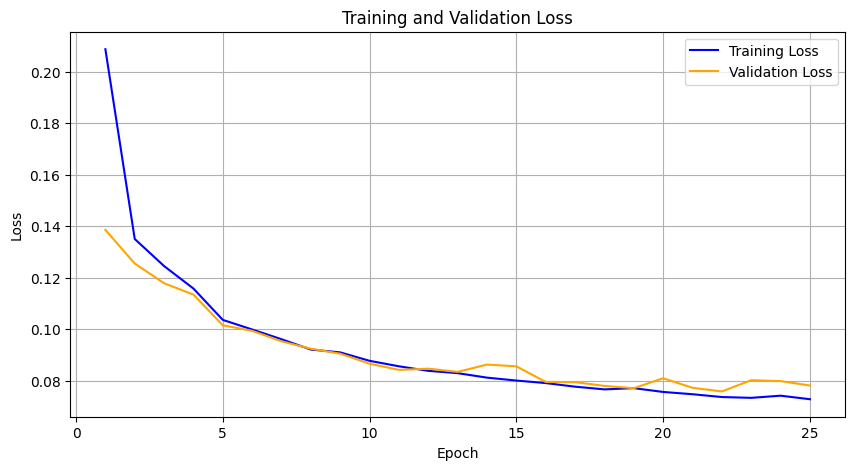

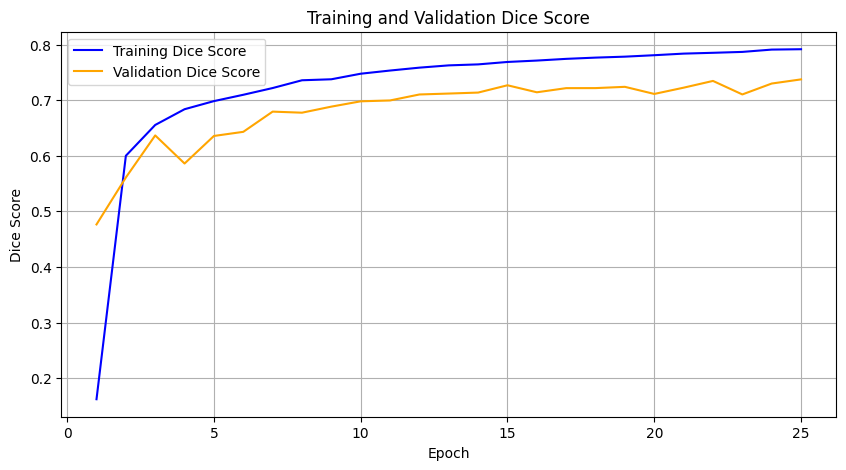

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation dice score
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_dice_score) + 1), train_dice_score, label='Training Dice Score', color='blue')
plt.plot(range(1, len(validation_dice_score) + 1), validation_dice_score, label='Validation Dice Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()
plt.grid(True)
plt.show()